In this part we are importing our libraries that we will use during our neural networks training (note that pandas will be used to turn the result to a csv file)

In [19]:
import numpy as np
import sys
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.python.keras.utils import np_utils
from keras.optimizers import SGD
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)  


here we are setting some constants that we will use later in our training

In [7]:

DEFAULT_BATCH_SIZE = 32
DEFAULT_NUMBER_HIDDEN = 2
DEFAULT_LEARNING_RATE = 0.01
NUM_CLASSES = 10  
EPOCHS = 5
results = []


we are using the mnist dataset (minst is a dataset of 28x28 images of handwritten digits and their labels
) which we are loading from keras and then splitting it into train and test data


In [8]:
(X_train_1, train_labels_1), (X_test, test_labels_1) = mnist.load_data()


- Reshapes `X_train_1` and `X_test` to have 784 columns each, converting 2D image data into 1D vectors for model input.
- Converts data types to `float32` for both datasets to ensure compatibility with machine learning frameworks and optimize memory usage

In [9]:
X_train_1 = X_train_1.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train_1 = X_train_1.astype('float32')
X_test = X_test.astype('float32')

Normalizes the training and testing datasets to a range of 0 to 1 by dividing by 255, improving model training efficiency by ensuring inputs are on a consistent scale.

its divided bu 255 because image data typically comes in the form of integers ranging from 0 to 255, representing the intensity of pixels in grayscale images (or each color channel in RGB images).

In [10]:
X_train_1 /= 255
X_test /= 255

Splits the preprocessed dataset into a training set with the first 50,000 samples and a validation set with the last 10,000 samples. 

In [11]:
# Divides the dataset into train and validation sets
X_valid = X_train_1[50000:60000]
X_train = X_train_1[:50000]
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')

50000 train samples
10000 validation samples


The label arrays are converted into a format that's more suitable for the model using the `np_utils.to_categorical` function. This process changes the training and testing labels into one-hot encoded vectors, determined by the total number of classes (`NUM_CLASSES`). In one-hot encoding, for each label, an array is created where all elements are 0 except for the position corresponding to the label, which is set to 1.

Following this transformation for both training and testing labels, a subset of the training labels is allocated for validation purposes (`valid_labels`), extracted from the last 10,000 entries of the one-hot encoded training labels. Consequently, the `train_labels` array is adjusted to contain only the first 50,000 entries to align with the dataset's split for training, validation, and testing.


In [12]:
train_labels = np_utils.to_categorical(train_labels_1, NUM_CLASSES)
test_labels = np_utils.to_categorical(test_labels_1, NUM_CLASSES)
valid_labels = train_labels[50000:60000]
train_labels = train_labels[:50000]

The function `create_model` is designed to easily experiment with different architectures by adjusting the number of hidden layers, input shape, and number of output classes. It allows for quick adjustments and testing of various configurations, facilitating the exploration of multiple combinations of hidden layers, batch sizes, and learning rates in the model training process.

In [13]:
def create_model(num_hidden_layers, input_shape, num_classes):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

here we are conducting a series of experiments to explore how different hyperparameters affect model performance. It iterates over sets of batch sizes, numbers of hidden layers, and learning rates, using a predefined function `create_model` to construct models with these varying configurations. For each configuration, the model is compiled and trained on a training set, then evaluated on a test set. The results, including hyperparameter values and model performance (accuracy and loss), are collected in a list and then converted into a DataFrame. This DataFrame is saved to a CSV file, `hyperparameter_tuning_results.csv`, allowing for easy analysis of how each hyperparameter impacts the model's effectiveness.


In [ ]:
for batch_num in [1, 2, 4, 8, 16, 32, 64, 128]:
    model = create_model(DEFAULT_NUMBER_HIDDEN, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=DEFAULT_LEARNING_RATE), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=batch_num, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=batch_num, verbose=1)

    results.append({'Hyperparameter': 'BatchSize', 
                    'Value': batch_num, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]}) 

for hidden_num in [1, 2, 4, 6, 8]:
    model = create_model(hidden_num, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=DEFAULT_LEARNING_RATE), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=DEFAULT_BATCH_SIZE, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=DEFAULT_BATCH_SIZE, verbose=1)
    results.append({'Hyperparameter': 'NumHiddenLayers', 
                    'Value': hidden_num, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]})

for learning_r in [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]:
    model = create_model(DEFAULT_NUMBER_HIDDEN, 784, NUM_CLASSES)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_r), metrics=['accuracy'])
    model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=DEFAULT_BATCH_SIZE, verbose=1, validation_data=(X_valid, valid_labels))
    score = model.evaluate(X_test, test_labels, batch_size=DEFAULT_BATCH_SIZE, verbose=1)
    results.append({'Hyperparameter': 'LearningRate', 
                    'Value': learning_r, 
                    'Default_BatchSize': DEFAULT_BATCH_SIZE,
                    'Default_NumHiddenLayers': DEFAULT_NUMBER_HIDDEN, 
                    'Default_LearningRate': DEFAULT_LEARNING_RATE, 
                    'Accuracy': score[1], 
                    'Loss': score[0]})

df = pd.DataFrame(results)

df.to_csv('hyperparameter_tuning_results.csv', index=False)


Loaded the tuning results into a DataFrame and picked out the batch sizes, hidden layer counts, accuracy, and loss. Made a grid over batch sizes and hidden layers and used it to guess accuracy and loss in between our actual data points. Started a plot to show this visually.

Looking at the plots, it's clear that upping the batch size improves accuracy and decreases loss until it hits a plateau around the 20-40 mark. Past that, cranking up the batch size doesn't make much of a dent. As for hidden layers, there's a point of diminishing returns there too, once you have a good amount, adding extra doesn't seem to boost performance. And about learning rate—there isn't a drastic change in accuracy with different rates, suggesting that once you nail the batch size and hidden layers, the learning rate can be fine-tuned for potentially better results, but it's not the main player.


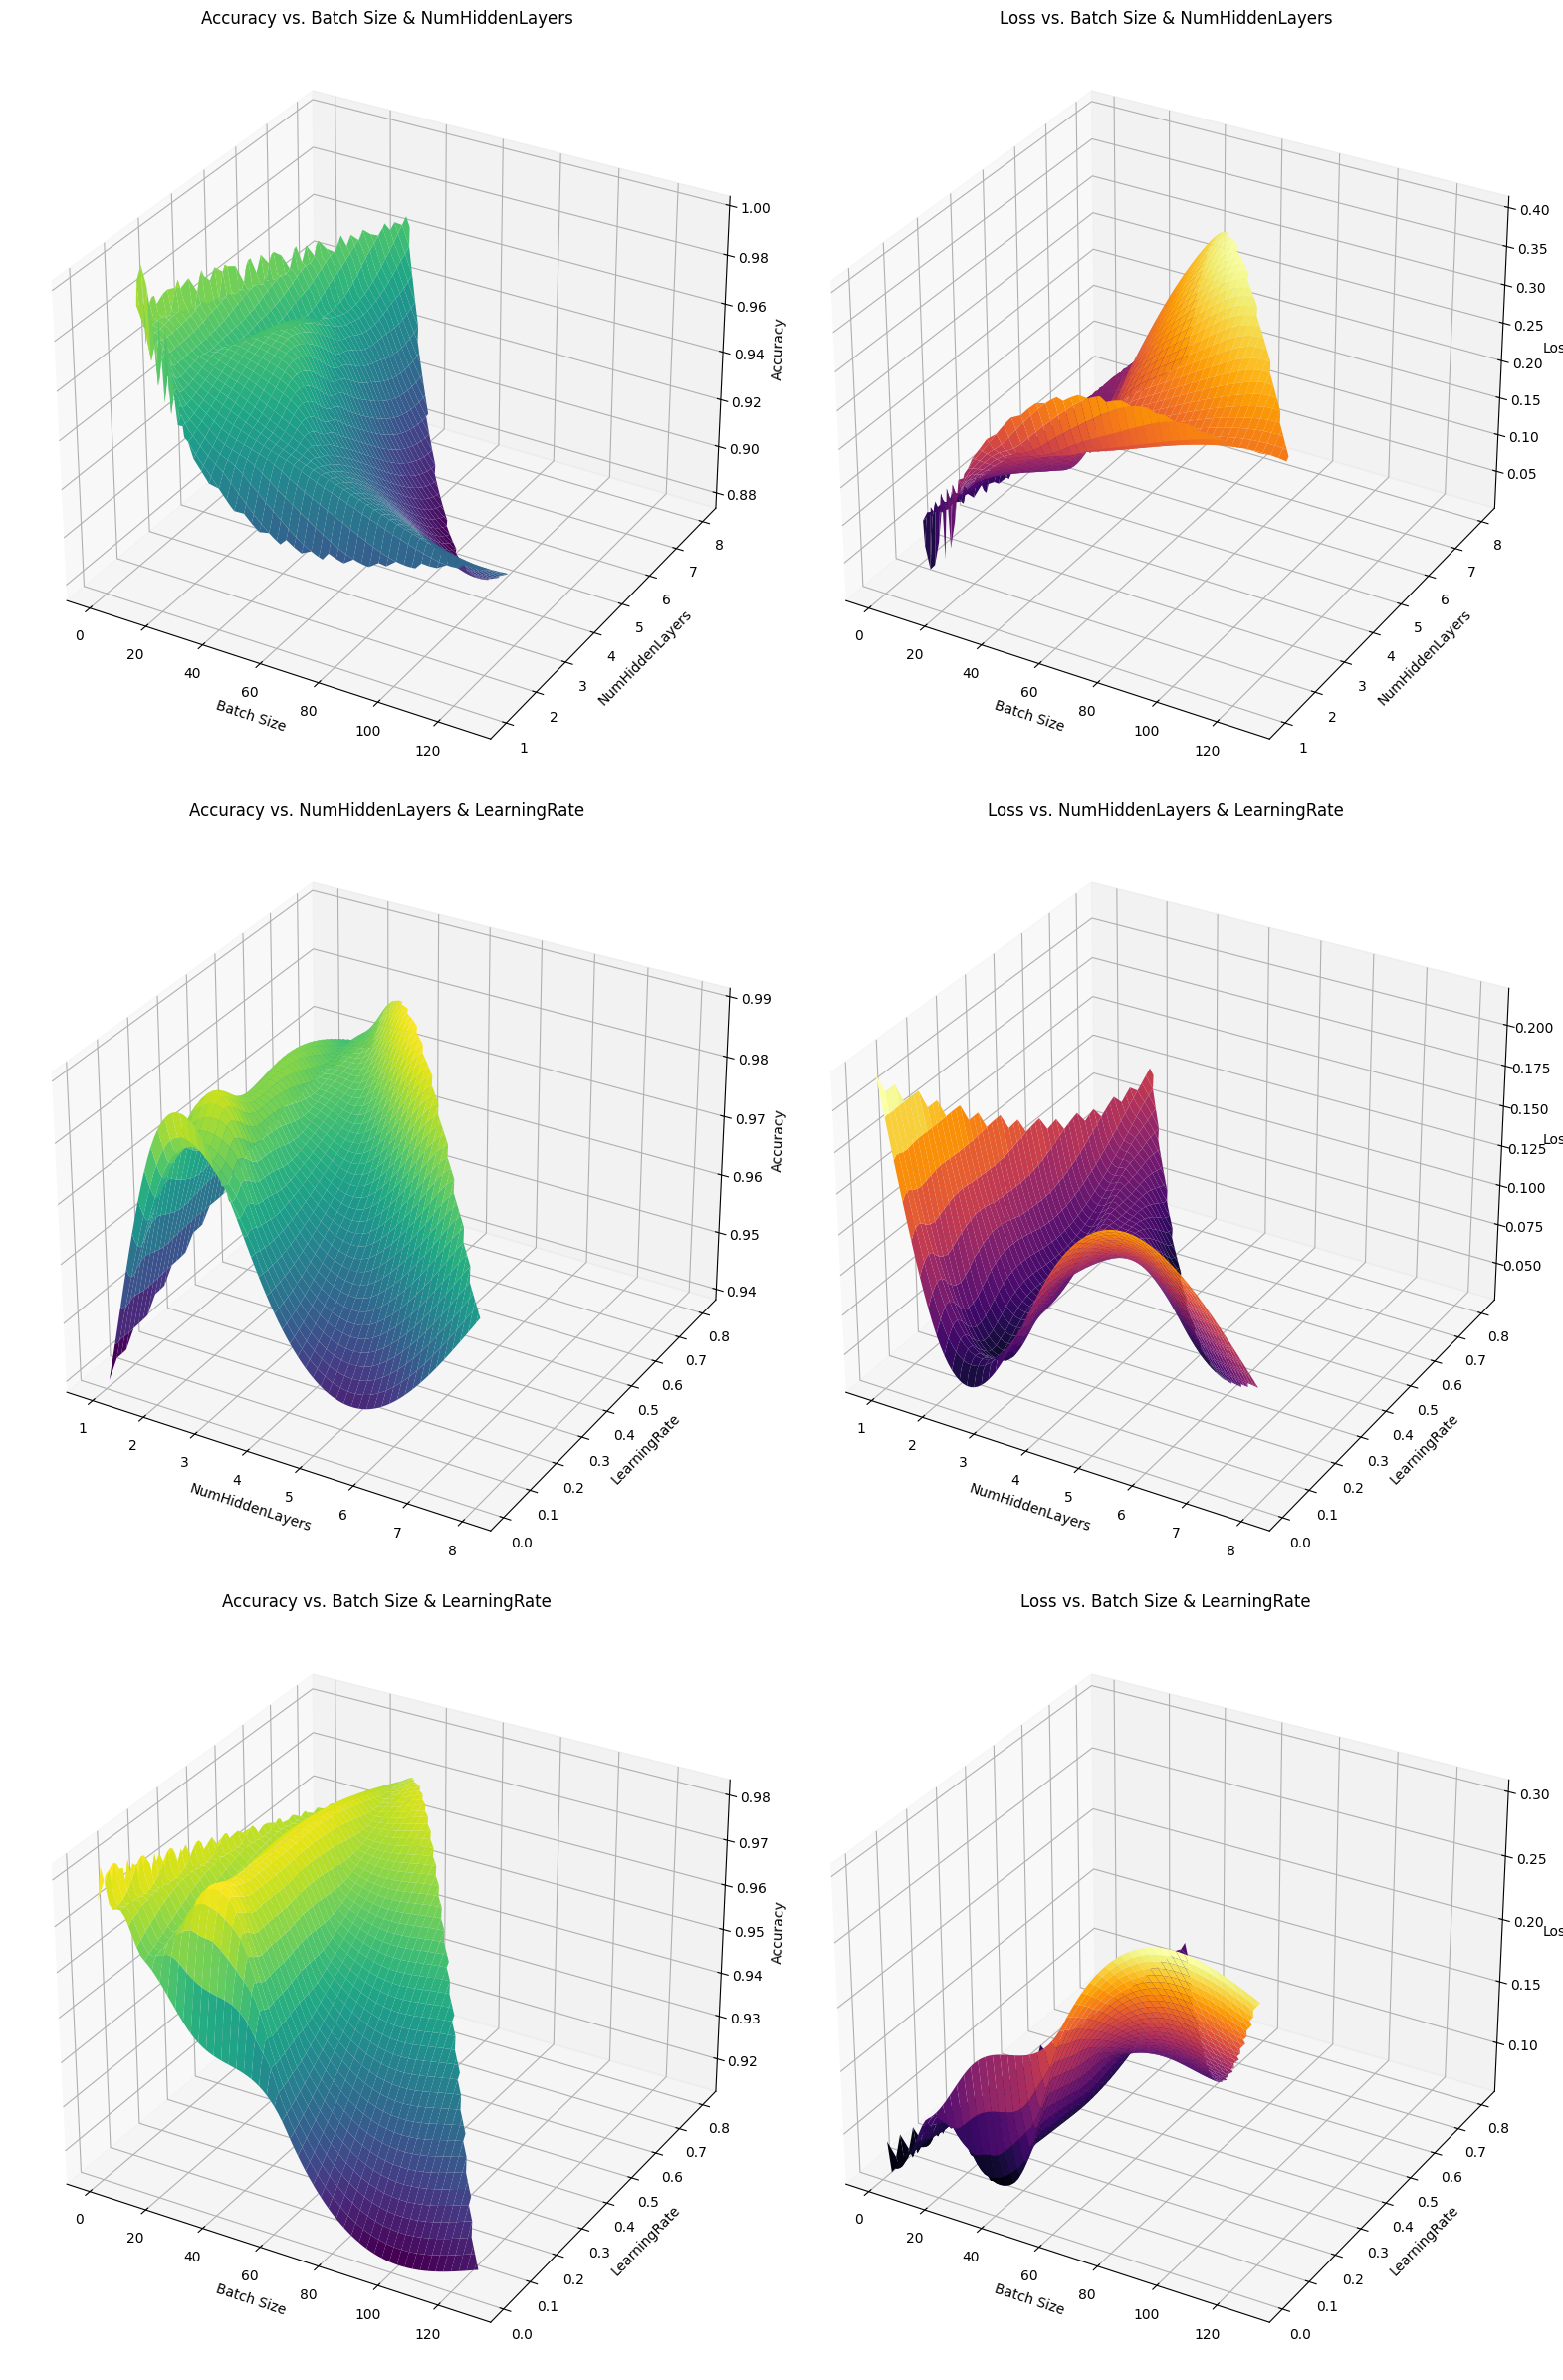

In [15]:
df = pd.read_csv('hyperparameter_tuning_results.csv')

x = df['BatchSize']
y = df['NumHiddenLayers']
z = df['LearningRate']
z1 = df['Accuracy']
z2 = df['Loss']

xi_bn = np.linspace(x.min(), x.max(), 100)
yi_bn = np.linspace(y.min(), y.max(), 100)
xi_bn, yi_bn = np.meshgrid(xi_bn, yi_bn)

zi1_bn = griddata((x, y), z1, (xi_bn, yi_bn), method='cubic')
zi2_bn = griddata((x, y), z2, (xi_bn, yi_bn), method='cubic')

yi_hl = np.linspace(y.min(), y.max(), 100)
zi_hl = np.linspace(z.min(), z.max(), 100)
yi_hl, zi_hl = np.meshgrid(yi_hl, zi_hl)

zi1_hl = griddata((y, z), z1, (yi_hl, zi_hl), method='cubic')
zi2_hl = griddata((y, z), z2, (yi_hl, zi_hl), method='cubic')

xi_lr = np.linspace(x.min(), x.max(), 100)
zi_lr = np.linspace(z.min(), z.max(), 100)
xi_lr, zi_lr = np.meshgrid(xi_lr, zi_lr)

zi1_lr = griddata((x, z), z1, (xi_lr, zi_lr), method='cubic')
zi2_lr = griddata((x, z), z2, (xi_lr, zi_lr), method='cubic')

fig = plt.figure(figsize=(16, 24))

# Plot for Accuracy vs. Batch Size & Number of Hidden Layers
ax1 = fig.add_subplot(3, 2, 1, projection='3d')
surf1 = ax1.plot_surface(xi_bn, yi_bn, zi1_bn, cmap='viridis', edgecolor='none')
ax1.set_title('Accuracy vs. Batch Size & NumHiddenLayers')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('NumHiddenLayers')
ax1.set_zlabel('Accuracy')

# Plot for Loss vs. Batch Size & Number of Hidden Layers
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
surf2 = ax2.plot_surface(xi_bn, yi_bn, zi2_bn, cmap='inferno', edgecolor='none')
ax2.set_title('Loss vs. Batch Size & NumHiddenLayers')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('NumHiddenLayers')
ax2.set_zlabel('Loss')

# Plot for Accuracy vs. NumHiddenLayers & Learning Rate
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
surf3 = ax3.plot_surface(yi_hl, zi_hl, zi1_hl, cmap='viridis', edgecolor='none')
ax3.set_title('Accuracy vs. NumHiddenLayers & LearningRate')
ax3.set_xlabel('NumHiddenLayers')
ax3.set_ylabel('LearningRate')
ax3.set_zlabel('Accuracy')

# Plot for Loss vs. NumHiddenLayers & Learning Rate
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
surf4 = ax4.plot_surface(yi_hl, zi_hl, zi2_hl, cmap='inferno', edgecolor='none')
ax4.set_title('Loss vs. NumHiddenLayers & LearningRate')
ax4.set_xlabel('NumHiddenLayers')
ax4.set_ylabel('LearningRate')
ax4.set_zlabel('Loss')

# Plot for Accuracy vs. Batch Size & Learning Rate
ax5 = fig.add_subplot(3, 2, 5, projection='3d')
surf5 = ax5.plot_surface(xi_lr, zi_lr, zi1_lr, cmap='viridis', edgecolor='none')
ax5.set_title('Accuracy vs. Batch Size & LearningRate')
ax5.set_xlabel('Batch Size')
ax5.set_ylabel('LearningRate')
ax5.set_zlabel('Accuracy')

# Plot for Loss vs. Batch Size & Learning Rate
ax6 = fig.add_subplot(3, 2, 6, projection='3d')
surf6 = ax6.plot_surface(xi_lr, zi_lr, zi2_lr, cmap='inferno', edgecolor='none')
ax6.set_title('Loss vs. Batch Size & LearningRate')
ax6.set_xlabel('Batch Size')
ax6.set_ylabel('LearningRate')
ax6.set_zlabel('Loss')

plt.tight_layout()
plt.show()

## Batch Size (batch-size.png)
The graph shows a downward trend in validation accuracy as the batch size increases. This could be due to the fact that larger batch sizes provide a more accurate estimate of the gradient, but smaller batches may offer a regularizing effect and more frequent updates, which can lead to better generalization. A smaller batch size also means the model is updated more frequently, which can lead to faster learning but also increased noise in the gradient estimation.

**Hypothesis**: Smaller batch sizes may be forcing the model to learn more robust features due to noise in the gradient estimates, leading to better generalization on the validation set.

## Learning Rate (learning-rate.png)
In this graph, the validation accuracy improves significantly as the learning rate increases from 0.01 to 0.05, then stabilizes and starts to decrease after 0.1. This suggests that a learning rate that is too low may not traverse the loss landscape efficiently, while a learning rate that is too high might overshoot optimal points.

**Hypothesis**: There's an optimal range of learning rates where the model learns efficiently without overshooting or getting stuck in local minima. Beyond this range, the learning either becomes inefficient (too low) or too erratic (too high).

## Number of Hidden Layers (num-hidden-layers.png)
The trend in this graph is less straightforward, showing a peak in accuracy at 4 hidden layers, followed by a dip at 6 layers, and then an increase at 8 layers. This could indicate that the model complexity appropriate for the given task is achieved at around 4 hidden layers, but further increases may lead to overfitting, which is possibly mitigated when the number of layers is increased to 8.

**Hypothesis**: The model complexity needed to capture the patterns in the data is met at a certain number of layers, beyond which the model might overfit. The subsequent increase in accuracy with more layers might be due to the model's ability to capture more abstract representations.

**General Considerations**
Accuracy should not be the only criterion for deciding a parameter setting. Other considerations include:

**Overfitting**: High accuracy on the validation set might not translate to the test set if the model has overfitted.
Training Time: Larger batch sizes and more hidden layers generally increase training time.
**Computational Resources**: More complex models with more layers and smaller batch sizes might require more memory and computational power.


In [16]:
model = create_model(2, 784, 10)

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

model.fit(X_train, train_labels, epochs=EPOCHS, batch_size=2, verbose=1, validation_data=(X_valid, valid_labels))

score = model.evaluate(X_test, test_labels, batch_size=2, verbose=1)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

Epoch 1/5
25000/25000 [==============================] - 134s 5ms/step - loss: 0.2326 - accuracy: 0.9300 - val_loss: 0.1323 - val_accuracy: 0.9597
Epoch 2/5
25000/25000 [==============================] - 126s 5ms/step - loss: 0.0942 - accuracy: 0.9711 - val_loss: 0.0882 - val_accuracy: 0.9744
Epoch 3/5
25000/25000 [==============================] - 118s 5ms/step - loss: 0.0610 - accuracy: 0.9813 - val_loss: 0.0866 - val_accuracy: 0.9739
Epoch 4/5
25000/25000 [==============================] - 119s 5ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.0740 - val_accuracy: 0.9787
Epoch 5/5
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0704 - accuracy: 0.9790
Test Loss: 0.07036794722080231, Test Accuracy: 0.9789999723434448


In [17]:
predictions = model.predict(X_valid)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(valid_labels, axis=1)

313/313 [==============================] - 1s 3ms/step


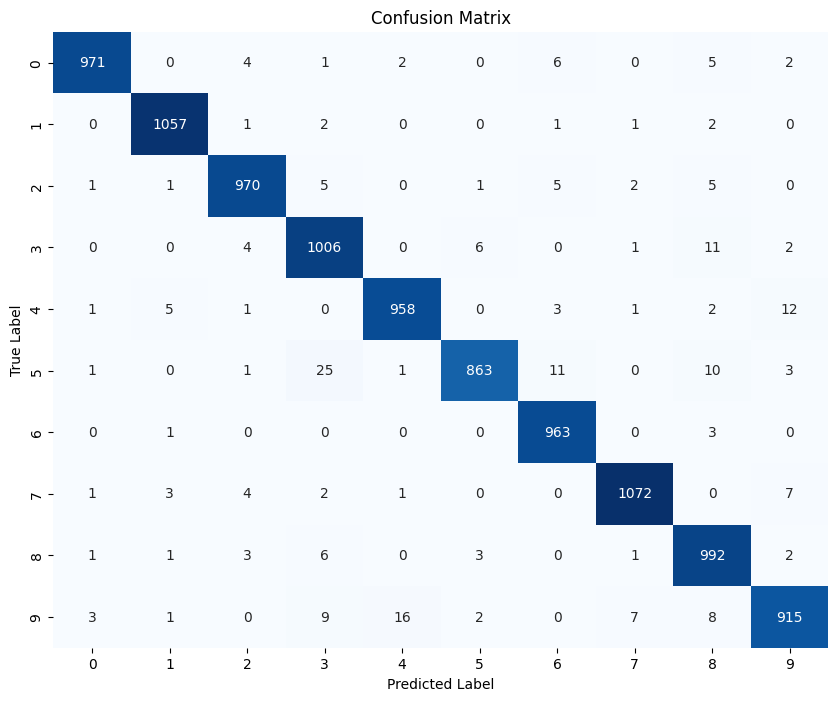

In [20]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

By looking at the off-diagonal elements, we should identify the cell with the highest number not on the diagonal. From the image, it appears that the classifier most frequently confuses between class 9 (true label) and class 4 (predicted label), with 16 instances being misclassified.

To fix the mix-up between two classes by my model, I'd get more examples for the confused class, play around with the features, and maybe change the model a bit. This should help the model tell the classes apart better.